In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import torch
print(torch.cuda.device_count())
import numpy as np
from math import *
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import cmcrameri.cm as cmc

%matplotlib inline
plt.style.use('/home/beams/B313762/stylesheet.mplstyle')

1


## Load data + pre-processing

In [2]:
data_folder = '/data/aileen/DONUT_data'

sim_mat = np.load(os.path.join(data_folder, 'sim_data.npy'))

sim_mat = np.reshape(sim_mat, (sim_mat.shape[0]*sim_mat.shape[1]*sim_mat.shape[2], 
                               sim_mat.shape[3], sim_mat.shape[4]))

print('Data shape: ', sim_mat.shape)

strain = np.linspace(-0.005, 0.005, 41)
tilt_lr = np.linspace(-0.05, 0.05, 41)
tilt_ud = np.linspace(-0.1, 0.1, 41)

labels = np.zeros((41, 41, 41, 3))
for p0 in range(labels.shape[0]):
    for p1 in range(labels.shape[1]):
        for p2 in range(labels.shape[2]):
            labels[p0, p1, p2] = np.array([strain[p0], tilt_lr[p1], tilt_ud[p2]])
labels = np.reshape(labels, (labels.shape[0]*labels.shape[1]*labels.shape[2], labels.shape[3]))
labels[:, 0] *= 100
labels[:, 1] *= 10
labels[:, 2] *= 5
labels = np.float32(np.around(labels, 5))

print('Labels shape: ', labels.shape)

# Normalize data from 0 to average experimental single shot maximum value
sim_mat[np.isnan(sim_mat)] = 0
for i in range(sim_mat.shape[0]):
    sim_mat[i] = (sim_mat[i] / np.max(sim_mat[i])) * 7
print('Normalized min. and max.: ', np.min(sim_mat), np.max(sim_mat))

# Add Poisson noise 
rng = np.random.default_rng()
for i in tqdm(range(sim_mat.shape[0])):
    sim_mat[i] = rng.poisson(sim_mat[i])

sim_mat = sim_mat.astype('float32')
print('Data type: ', sim_mat.dtype)

Data shape:  (68921, 64, 64)
Labels shape:  (68921, 3)
Normalized min. and max.:  0.0 7.0


  0%|          | 0/68921 [00:00<?, ?it/s]

Data type:  float32


In [3]:
# Load experimental data
data = np.load(os.path.join(data_folder, 'dataSIO.npy')).astype('float32')

# Load correlation fit results for experimental data comparison 
fit_folder = '/data/aileen/NanobeamNN/data'
fit_strain_exp = np.load(os.path.join(fit_folder, 'strain_fit190_test.npy'))
fit_tilt_lr_exp = np.load(os.path.join(fit_folder, 'tilt_lr_fit190_test.npy'))
fit_tilt_ud_exp = np.load(os.path.join(fit_folder, 'tilt_ud_fit190_test.npy'))

fit_strain_exp = np.reshape(fit_strain_exp, (165, 165))
fit_tilt_lr_exp = np.reshape(fit_tilt_lr_exp, (165, 165))
fit_tilt_ud_exp = np.reshape(fit_tilt_ud_exp, (165, 165))

fit_strain_exp -= np.mean(fit_strain_exp)
fit_tilt_lr_exp -= np.mean(fit_tilt_lr_exp)
fit_tilt_ud_exp -= np.mean(fit_tilt_ud_exp)

## Convert to PyTorch Dataset

In [4]:
class DiffDataset(Dataset):
    """Makes PyTorch Dataset object for diffraction data (images)."""
    
    def __init__(self, data, params=None, transform=None):
        self.data = data
        if isinstance(params, np.ndarray):
            self.params = params
        else:
            self.params = None
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = self.data[idx]
        if isinstance(self.params, np.ndarray):
            lattice = self.params[idx]
            sample={'image': image, 'lattice': lattice}
        else:
            sample = {'image': image, 'lattice': None}
            
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert numpy arrays to Tensors"""
    def __call__(self, sample):
        image = sample['image']
        if isinstance(sample['lattice'], np.ndarray):
            lattice = sample['lattice']
            return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': torch.from_numpy(lattice)}
        return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': 0}

In [5]:
diff_dataset = DiffDataset(data=sim_mat, params=labels, transform=ToTensor())
exp_dataset = DiffDataset(data=data, params=None, transform=ToTensor())

for i, sample in enumerate(diff_dataset):
    print(i, sample['image'].size())
    print(sample['image'].dtype)
    
    if i == 4:
        break

0 torch.Size([1, 64, 64])
torch.float32
1 torch.Size([1, 64, 64])
torch.float32
2 torch.Size([1, 64, 64])
torch.float32
3 torch.Size([1, 64, 64])
torch.float32
4 torch.Size([1, 64, 64])
torch.float32


In [6]:
# Split into training, validation, and test sets

generator0 = torch.Generator().manual_seed(8)
subsets = torch.utils.data.random_split(diff_dataset, [0.8, 0.1, 0.1], generator=generator0)

## Hyperparameters and constants

In [7]:
BATCH_SIZE = 64
MODEL_SAVE_PATH = '/home/beams/AILEENLUO/DONUT/models'

In [8]:
# Use a DataLoader to iterate through the Dataset
trainloader = DataLoader(subsets[0], batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(subsets[1], batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(subsets[2], batch_size=BATCH_SIZE, shuffle=False)

dataloader = DataLoader(exp_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model definition

In [9]:
class MCDropout(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super().__init__()
        self.p = dropout_rate
       
    def forward(self, x: torch.Tensor):
        return nn.functional.dropout(x, p=self.p, training=True)
    
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), 
            MCDropout(dropout_rate),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            MCDropout(dropout_rate)
        )
        
    def forward(self, x: torch.Tensor):
        return self.conv(x)

# Autoencoder building blocks
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, x: torch.Tensor):
        return self.pool(x)
    
class UpSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        
    def forward(self, x: torch.Tensor):
        return self.up(x)
    
class DoubleConvUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            MCDropout(dropout_rate),
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), 
            MCDropout(dropout_rate)
        )
        
    def forward(self, x: torch.Tensor):
        return self.conv(x)

In [10]:
class Encoder(nn.Module):
    def __init__(self, in_channels: int, dropout_rate=0.0):
        super().__init__()
        self.down_conv = nn.ModuleList([DoubleConv(i, o, dropout_rate) for i, o in 
                                        [(in_channels, 8), (8, 16), (16, 32), (32, 64), (64, 128), (128, 256)]])
        self.down_sample = nn.ModuleList([DownSample() for _ in range(6)])
        self.fc = nn.Linear(256, 3)
        
    def forward(self, x: torch.Tensor):
        for i in range(len(self.down_conv)):
            x = self.down_conv[i](x)
            x = self.down_sample[i](x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.up_sample = UpSample()
        self.up_conv = nn.ModuleList([DoubleConvUp(i, o, dropout_rate) for i, o in 
                                      [(256, 128), (128, 64), (64, 32), (32, 16), (16, 8),
                                       (8, out_channels)]])
        self.inv_fc = nn.Linear(3, 256)
        
    def forward(self, x: torch.Tensor):
        x = self.inv_fc(x)
        x = x.view(x.shape[0], 256, 1, 1)
        for i in range(len(self.up_conv)):
            x = self.up_sample(x)
            x = self.up_conv[i](x)
        return x

## Monte Carlo dropout

In [11]:
cnn = Encoder(1, 0.1)
cnn.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'mcdropout_encoder.pth'), map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_predictions(model, dataloader, encoder_only=True, batch_size=BATCH_SIZE, device=DEVICE):
    """Returns network predictions and labels by any model on any dataset."""
    
    pred_vals = np.zeros((len(dataloader)-1, batch_size, 3))
    if encoder_only == False:
        pred_imgs = np.zeros((len(dataloader)-1, batch_size, 64, 64))
        pred_recon = np.zeros((len(dataloader)-1, batch_size, 64, 64))
        gt_imgs = np.zeros(pred_imgs.shape)
    gt_vals = np.zeros(pred_vals.shape)
    model.to(device)
    print(next(model.parameters()).device)
    inference_time = []
    t0 = time.time()
    
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader)):
            t1 = time.time()
            images = data['image'].to(device)
            if isinstance(data['lattice'], torch.Tensor):
                labels = data['lattice'].to(device)
            if encoder_only == False:
                output_recon, output_imgs, output_vals = model(images)
            else: 
                output_enc = model(images)
                output_vals = 1.7159 * torch.tanh((2/3) * output_enc)
            if i < pred_vals.shape[0]:
                pred_vals[i] = output_vals.detach().cpu().numpy()
                if encoder_only == False:
                    pred_imgs[i] = output_imgs.squeeze().detach().cpu().numpy()
                    pred_recon[i] = output_recon.squeeze().detach().cpu().numpy()
                    gt_imgs[i] = images.squeeze().detach().cpu().numpy()
                if isinstance(data['lattice'], torch.Tensor) and data['lattice'].shape==(data['lattice'].shape[0], 3):
                    gt_vals[i] = labels.detach().cpu().numpy()
                inference_time.append(time.time()-t1)
            else:
                # The last batch may be a different size
                pred_vals_last = output_vals.detach().cpu().numpy()
                gt_vals_last = np.zeros(pred_vals_last.shape)
                if encoder_only == False:
                    pred_imgs_last = output_imgs.squeeze(dim=1).detach().cpu().numpy()
                    pred_recon_last = output_recon.squeeze(dim=1).detach().cpu().numpy()
                    gt_imgs_last = images.squeeze().detach().cpu().numpy()
                    if gt_imgs_last.ndim == 2:
                        gt_imgs_last = gt_imgs_last[np.newaxis, :, :]
                if isinstance(data['lattice'], torch.Tensor) and data['lattice'].shape==(data['lattice'].shape[0], 3):
                    gt_vals_last = labels.detach().cpu().numpy()
                inference_time.append(time.time()-t1)
    
    print('Total inference time (s): ', time.time()-t0)
    print('Average inference time (s): ', np.mean(inference_time[2:len(inference_time)-1])/batch_size)
    print('Inference time error (s): ', np.std(inference_time[2:len(inference_time)-1])/batch_size)
    pred_vals = np.reshape(pred_vals, (pred_vals.shape[0]*pred_vals.shape[1], pred_vals.shape[2]))
    if encoder_only == False:
        pred_imgs = np.reshape(pred_imgs, (pred_imgs.shape[0]*pred_imgs.shape[1], 
                                           pred_imgs.shape[2], pred_imgs.shape[3]))
        pred_recon = np.reshape(pred_recon, (pred_recon.shape[0]*pred_recon.shape[1], pred_recon.shape[2],
                                             pred_recon.shape[3]))
        gt_imgs = np.reshape(gt_imgs, (gt_imgs.shape[0]*gt_imgs.shape[1], gt_imgs.shape[2], gt_imgs.shape[3]))
        pred_imgs = np.vstack((pred_imgs, pred_imgs_last))
        pred_recon = np.vstack((pred_recon, pred_recon_last))
        gt_imgs = np.vstack((gt_imgs, gt_imgs_last))
    gt_vals = np.reshape(gt_vals, (gt_vals.shape[0]*gt_vals.shape[1], gt_vals.shape[2]))
    pred_vals = np.vstack((pred_vals, pred_vals_last))
    gt_vals = np.vstack((gt_vals, gt_vals_last))
    if encoder_only == False:
        return pred_vals, pred_imgs, pred_recon, gt_vals, gt_imgs
    return pred_vals, gt_vals

In [13]:
def get_MCDropout_predictions(model, dataloader, dataset, sim_only=False):
    all_pred_vals = np.zeros((30, len(dataset), 3))
    all_gt_vals = np.zeros((30, len(dataset), 3))
    for i in range(all_pred_vals.shape[0]):
        pred_vals, gt_vals = get_predictions(model, dataloader)
        all_pred_vals[i] = pred_vals
        all_gt_vals[i] = gt_vals
    return all_pred_vals, all_gt_vals

In [14]:
mcdropout_preds_exp, _ = get_MCDropout_predictions(cnn, dataloader, exp_dataset)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  1.0226306915283203
Average inference time (s):  2.0226397624252537e-05
Inference time error (s):  6.805955929124103e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7391536235809326
Average inference time (s):  2.0230052459888143e-05
Inference time error (s):  3.0376464210664115e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7366878986358643
Average inference time (s):  2.01727463984884e-05
Inference time error (s):  2.8928519412894054e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7377736568450928
Average inference time (s):  2.0180223399583893e-05
Inference time error (s):  2.7721477048974775e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7379252910614014
Average inference time (s):  2.019057142819073e-05
Inference time error (s):  3.04965448425287e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7383484840393066
Average inference time (s):  2.0199290192719048e-05
Inference time error (s):  3.338452464942516e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7395455837249756
Average inference time (s):  2.0204997020410308e-05
Inference time error (s):  3.150472777560006e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7394633293151855
Average inference time (s):  2.0205930544693137e-05
Inference time error (s):  3.07581725639404e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7407665252685547
Average inference time (s):  2.025255391783748e-05
Inference time error (s):  1.0260137802829647e-06
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7385497093200684
Average inference time (s):  2.0191038190332146e-05
Inference time error (s):  3.108456713534866e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7376220226287842
Average inference time (s):  2.01638603041358e-05
Inference time error (s):  2.970782750842539e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7391667366027832
Average inference time (s):  2.0214975162037156e-05
Inference time error (s):  3.1550789719128666e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7374403476715088
Average inference time (s):  2.014905601810338e-05
Inference time error (s):  2.98126745780307e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7408998012542725
Average inference time (s):  2.0256790004441642e-05
Inference time error (s):  4.854641689520427e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7406046390533447
Average inference time (s):  2.02319195084538e-05
Inference time error (s):  3.1611519182664886e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7382125854492188
Average inference time (s):  2.0206221170177414e-05
Inference time error (s):  2.9538269459942893e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7390480041503906
Average inference time (s):  2.0183261756919518e-05
Inference time error (s):  2.8177133879396225e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7411229610443115
Average inference time (s):  2.024490078008485e-05
Inference time error (s):  2.848417426707125e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7395279407501221
Average inference time (s):  2.0234649626639435e-05
Inference time error (s):  3.120771146094394e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7407894134521484
Average inference time (s):  2.0253989431593152e-05
Inference time error (s):  3.5174419891870346e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7395870685577393
Average inference time (s):  2.0208801572204483e-05
Inference time error (s):  3.100435251997994e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7404079437255859
Average inference time (s):  2.0229964391559573e-05
Inference time error (s):  2.9389484039013096e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7405009269714355
Average inference time (s):  2.024948033317043e-05
Inference time error (s):  2.888869058294529e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7401893138885498
Average inference time (s):  2.0222223185478373e-05
Inference time error (s):  3.084975008787647e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.740363359451294
Average inference time (s):  2.0234614399308007e-05
Inference time error (s):  3.0850947268563425e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7399225234985352
Average inference time (s):  2.020946208466875e-05
Inference time error (s):  3.068263790249067e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.739978551864624
Average inference time (s):  2.0215908686319988e-05
Inference time error (s):  3.008247202580516e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.739980936050415
Average inference time (s):  2.022260187929122e-05
Inference time error (s):  3.0470875607996485e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7421097755432129
Average inference time (s):  2.0282136069403754e-05
Inference time error (s):  2.934345699038792e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7421367168426514
Average inference time (s):  2.0277107367842474e-05
Inference time error (s):  2.93069952001584e-07


In [15]:
# Simulated dataset is large enough to give sufficient statistics
pred_vals_train, gt_vals_train = get_predictions(cnn, trainloader)
pred_vals_test, gt_vals_test = get_predictions(cnn, testloader) 

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  1.7608847618103027
Average inference time (s):  2.2354148701266998e-05
Inference time error (s):  2.965912558247759e-06
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.23392772674560547
Average inference time (s):  2.0616537048703147e-05
Inference time error (s):  4.649256376822594e-07


## Statistics

In [16]:
all_strain_exp = mcdropout_preds_exp[:, :, 0]/100
all_tilt_lr_exp = mcdropout_preds_exp[:, :, 1]/10
all_tilt_ud_exp = mcdropout_preds_exp[:, :, 2]/5

avg_strain_exp = np.reshape(np.mean(all_strain_exp, axis=0), (165, 165))
avg_strain_exp -= np.mean(avg_strain_exp)
avg_tilt_lr_exp = np.reshape(np.mean(all_tilt_lr_exp, axis=0), (165 ,165))
avg_tilt_lr_exp -= np.mean(avg_tilt_lr_exp)
avg_tilt_ud_exp = np.reshape(np.mean(all_tilt_ud_exp, axis=0), (165, 165))
avg_tilt_ud_exp -= np.mean(avg_tilt_ud_exp)

std_strain_exp = np.reshape(np.std(all_strain_exp, axis=0), (165, 165))
std_tilt_lr_exp = np.reshape(np.std(all_tilt_lr_exp, axis=0), (165, 165))
std_tilt_ud_exp = np.reshape(np.std(all_tilt_ud_exp, axis=0), (165, 165))

In [17]:
strain_label_range = np.linspace(-0.005, 0.005, 41)*100
print('Strain label range: ', strain_label_range)
tilt_lr_label_range = np.linspace(-0.05, 0.05, 41)*10
print('Tilt_lr label range: ', tilt_lr_label_range)
tilt_ud_label_range = np.linspace(-0.1, 0.1, 41)*5
print('Tilt_ud label range: ', tilt_ud_label_range)

Strain label range:  [-0.5   -0.475 -0.45  -0.425 -0.4   -0.375 -0.35  -0.325 -0.3   -0.275
 -0.25  -0.225 -0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025
  0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475
  0.5  ]
Tilt_lr label range:  [-0.5   -0.475 -0.45  -0.425 -0.4   -0.375 -0.35  -0.325 -0.3   -0.275
 -0.25  -0.225 -0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025
  0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475
  0.5  ]
Tilt_ud label range:  [-0.5   -0.475 -0.45  -0.425 -0.4   -0.375 -0.35  -0.325 -0.3   -0.275
 -0.25  -0.225 -0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025
  0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475
  0.5  ]


In [18]:
def make_idx_dict(label_arr):
    """Returns three dictionaries with labels as keys and numpy arrays of indices where the label is the key.
    label_arr: numpy array of labels
    """
    idx_dict_s = dict.fromkeys(strain_label_range)
    idx_dict_lr = dict.fromkeys(tilt_lr_label_range)
    idx_dict_ud = dict.fromkeys(tilt_ud_label_range)
    for strain_label in strain_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 0], 3) == np.around(strain_label, 3))
        idx_dict_s[strain_label] = val_arr
    for lr_label in tilt_lr_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 1], 3) == np.around(lr_label, 3))
        idx_dict_lr[lr_label] = val_arr
    for ud_label in tilt_ud_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 2], 3) == np.around(ud_label, 3))
        idx_dict_ud[ud_label] = val_arr
    return idx_dict_s, idx_dict_lr, idx_dict_ud

def test_make_idx_dict(idx_dict):
    """Return the total number of indices accounted for. It should be equal to the total number of labels."""
    counter = 0
    for key in idx_dict.keys():
        counter += idx_dict[key].shape[0]
    return counter

In [19]:
# Make dictionaries for training and test labels
train_s, train_lr, train_ud = make_idx_dict(gt_vals_train)
print('Train set indices: ', test_make_idx_dict(train_s), test_make_idx_dict(train_lr), 
      test_make_idx_dict(train_ud))
test_s, test_lr, test_ud = make_idx_dict(gt_vals_test)
print('Test set indices: ', test_make_idx_dict(test_s), test_make_idx_dict(test_lr), 
      test_make_idx_dict(test_ud))

Train set indices:  55137 55137 55137
Test set indices:  6892 6892 6892


In [20]:
def get_pred_err_stats(idx_arr, pred_arr, param_num):
    """Returns the mean and standard deviation of the prediction error for all parameters. Helper function for 
    combine_stats.
    idx_arr: array of indices
    pred_arr: array of predictions on a set of data
    param_num: 0 = strain, 1 = tilt_lr, 2 = tilt_ud
    """
    temp = np.zeros((idx_arr.shape[0], ))
    j = 0
    for idx in idx_arr:
        temp[j] = pred_arr[idx[0], param_num]
        j += 1
    return np.mean(temp), np.std(temp)

def combine_stats(idx_dict_s, idx_dict_lr, idx_dict_ud, pred_arr):
    """Combines the prediction errors of a parameter into an array using indices taken from the keys of the
    index dictionaries.
    idx_dict_s: dictionary of strain label values (keys) and index positions (values)
    idx_dict_lr: dictionary of tilt_lr label values and index positions
    idx_dict_ud: dictionary of tilt_ud label values and index positions
    pred_arr: array of predictions on a set of data
    """
    stats_arr_s = np.zeros((len(idx_dict_s), 2))
    stats_arr_lr = np.zeros((len(idx_dict_lr), 2))
    stats_arr_ud = np.zeros((len(idx_dict_ud), 2))
    counter_s = 0
    counter_lr = 0
    counter_ud = 0
    for key in idx_dict_s.keys():
        i_arr = idx_dict_s[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 0)
        stats_arr_s[counter_s, 0] = avg
        stats_arr_s[counter_s, 1] = stddev
        counter_s += 1
    for key in idx_dict_lr.keys():
        i_arr = idx_dict_lr[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 1)
        stats_arr_lr[counter_lr, 0] = avg
        stats_arr_lr[counter_lr, 1] = stddev
        counter_lr += 1
    for key in idx_dict_ud.keys():
        i_arr = idx_dict_ud[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 2)
        stats_arr_ud[counter_ud, 0] = avg
        stats_arr_ud[counter_ud, 1] = stddev
        counter_ud += 1
    return stats_arr_s, stats_arr_lr, stats_arr_ud

In [21]:
# Make arrays of mean and std. dev. of predictions for each parameter and label value for ease of plotting

train_stats_s, train_stats_lr, train_stats_ud = combine_stats(train_s, train_lr, train_ud, pred_vals_train)
test_stats_s, test_stats_lr, test_stats_ud = combine_stats(test_s, test_lr, test_ud, pred_vals_test)

## Visualizations

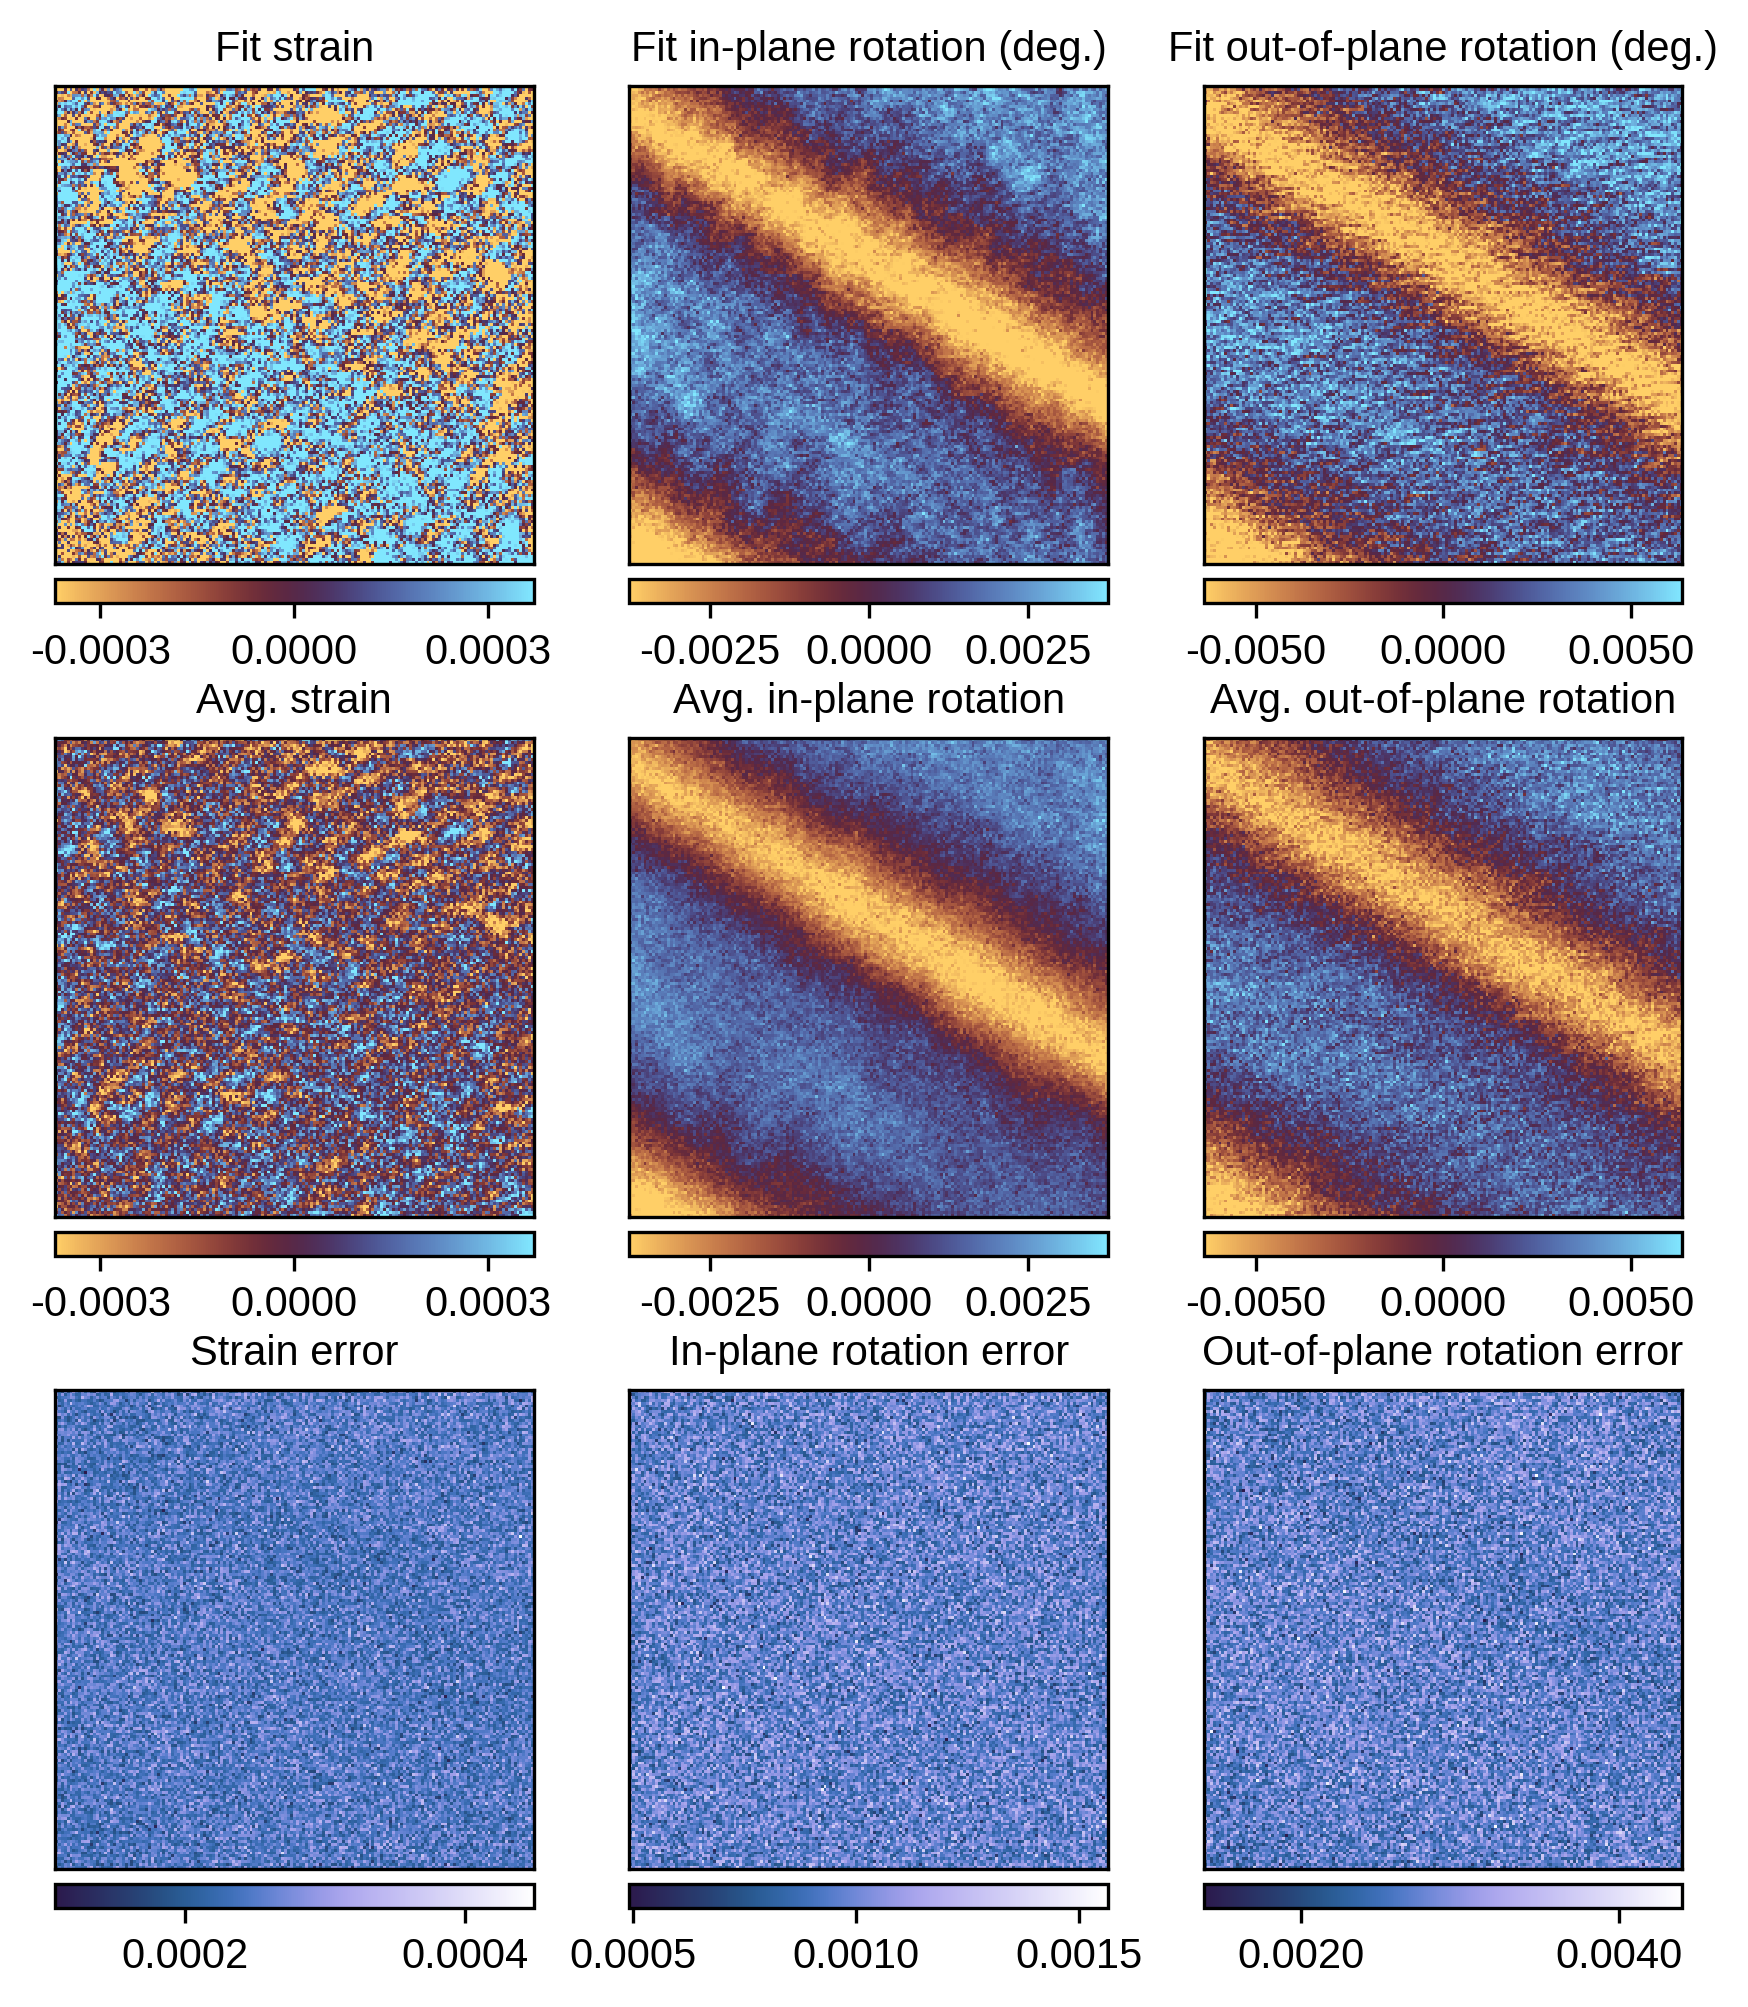

In [23]:
# Refer to Figure S2

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 8), nrows=3, ncols=3)

vmin0 = np.mean(avg_strain_exp) - (2 * np.std(avg_strain_exp))
vmax0 = np.mean(avg_strain_exp) + (2 * np.std(avg_strain_exp))
vmin1 = np.mean(avg_tilt_lr_exp) - (2 * np.std(avg_tilt_lr_exp))
vmax1 = np.mean(avg_tilt_lr_exp) + (2 * np.std(avg_tilt_lr_exp))
vmin2 = np.mean(avg_tilt_ud_exp) - (2 * np.std(avg_tilt_ud_exp))
vmax2 = np.mean(avg_tilt_ud_exp) + (2 * np.std(avg_tilt_ud_exp))

im0 = ax[0, 0].imshow(fit_strain_exp, interpolation='none', origin='lower', 
                      vmin=vmin0, vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 0].set_title('Fit strain')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(fit_tilt_lr_exp, interpolation='none', origin='lower', 
                      vmin=vmin1, vmax=vmax1, cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('Fit in-plane rotation (deg.)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(fit_tilt_ud_exp, interpolation='none', origin='lower', 
                      vmin=vmin2, vmax=vmax2, cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 2].set_title('Fit out-of-plane rotation (deg.)')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

fit_im0 = ax[1, 0].imshow(avg_strain_exp, interpolation='none', origin='lower', vmin=vmin0, 
                          vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im0, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 0].set_title('Avg. strain')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

fit_im1 = ax[1, 1].imshow(avg_tilt_lr_exp, interpolation='none', origin='lower', vmin=vmin1, vmax=vmax1, 
                          cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Avg. in-plane rotation')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

fit_im2 = ax[1, 2].imshow(avg_tilt_ud_exp, interpolation='none', origin='lower', vmin=vmin2, vmax=vmax2, 
                          cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im2, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 2].set_title('Avg. out-of-plane rotation')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

pred_im0 = ax[2, 0].imshow(std_strain_exp, interpolation='none', origin='lower', cmap=cmc.devon)
divider = make_axes_locatable(ax[2, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im0, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 0].set_title('Strain error')
ax[2, 0].set_xticks([])
ax[2, 0].set_yticks([])

pred_im1 = ax[2, 1].imshow(std_tilt_lr_exp, interpolation='none', origin='lower', cmap=cmc.devon)
divider = make_axes_locatable(ax[2, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im1, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 1].set_title('In-plane rotation error')
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])

pred_im2 = ax[2, 2].imshow(std_tilt_ud_exp, interpolation='none', origin='lower', cmap=cmc.devon)
divider = make_axes_locatable(ax[2, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im2, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 2].set_title('Out-of-plane rotation error')
ax[2, 2].set_xticks([])
ax[2, 2].set_yticks([])

f.savefig('figs2.svg', dpi=300, bbox_inches='tight', transparent=True)

Text(0.5, 0.98, 'Parity plot')

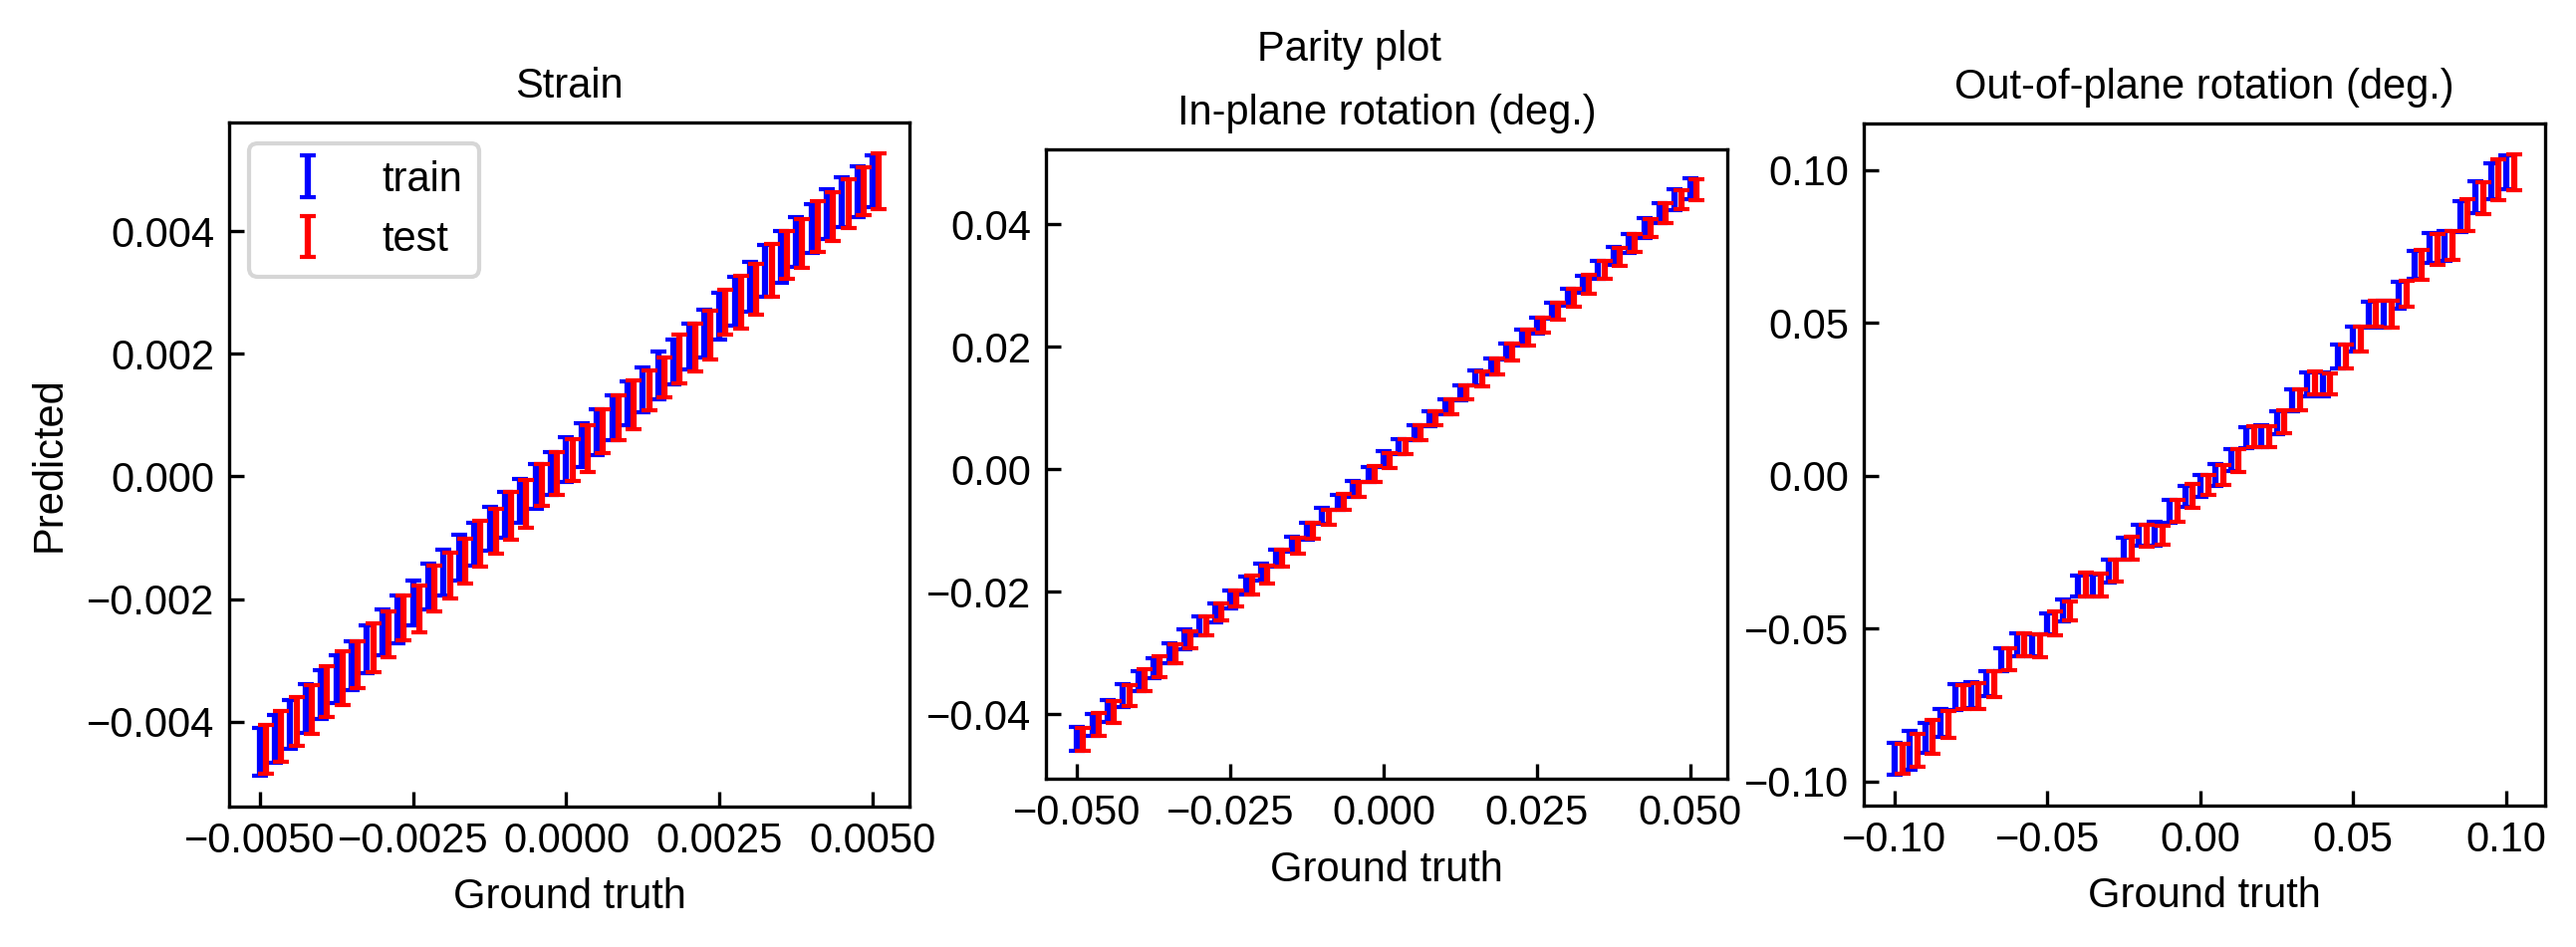

In [24]:
f, ax = plt.subplots(figsize=(10, 3), ncols=3)

ax[0].errorbar(np.linspace(-0.005, 0.005, 41), train_stats_s[:, 0]/100, yerr=train_stats_s[:, 1]/100, 
               label='train', fmt='none', capsize=2, color='blue')
ax[0].errorbar(np.linspace(-0.005, 0.005, 41)+0.0001, test_stats_s[:, 0]/100, 
               yerr=test_stats_s[:, 1]/100, label='test', fmt='none', capsize=2, color='red')
ax[0].set_xlabel('Ground truth')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Strain')
ax[0].set_aspect(1)
ax[0].tick_params(which='both', direction='in')
ax[0].legend()

ax[1].errorbar(np.linspace(-0.05, 0.05, 41), train_stats_lr[:, 0]/10, yerr=train_stats_lr[:, 1]/10, 
               label='train', fmt='none', capsize=2, color='blue')
ax[1].errorbar(np.linspace(-0.05, 0.05, 41)+0.001, test_stats_lr[:, 0]/10, yerr=test_stats_lr[:, 1]/10, 
               label='test', fmt='none', capsize=2, color='red')
ax[1].set_xlabel('Ground truth')
#ax[1].set_ylabel('Predicted')
ax[1].set_title('In-plane rotation (deg.)')
ax[1].tick_params(which='both', direction='in')
ax[1].set_aspect(1)

ax[2].errorbar(np.linspace(-0.1, 0.1, 41), train_stats_ud[:, 0]/5, yerr=train_stats_ud[:, 1]/5, 
               label='train', fmt='none', capsize=2, color='blue')
ax[2].errorbar(np.linspace(-0.1, 0.1, 41)+0.0025, test_stats_ud[:, 0]/5, yerr=test_stats_ud[:, 1]/5, 
               label='test', fmt='none', capsize=2, color='red')
ax[2].set_xlabel('Ground truth')
#ax[2].set_ylabel('Predicted')
ax[2].set_title('Out-of-plane rotation (deg.)')
ax[2].tick_params(which='both', direction='in')
ax[2].set_aspect(1)

f.suptitle('Parity plot')

In [25]:
x0 = gt_vals_train[:, 0]/100 - pred_vals_train[:, 0]/100
y0 = gt_vals_test[:, 0]/100 - pred_vals_test[:, 0]/100
range0 = np.max([np.abs(x0.min()), np.abs(x0.max()), np.abs(y0.min()), np.abs(y0.max())])
bins0 = np.linspace(-range0, range0, 20)

x1 = gt_vals_train[:, 1]/10 - pred_vals_train[:, 1]/10
y1 = gt_vals_test[:, 1]/10 - pred_vals_test[:, 1]/10
range1 = np.max([np.abs(x1.min()), np.abs(x1.max()), np.abs(y1.min()), np.abs(y1.max())])
bins1 = np.linspace(-range1, range1, 20)

x2 = gt_vals_train[:, 2]/10 - pred_vals_train[:, 2]/10
y2 = gt_vals_test[:, 2]/10 - pred_vals_test[:, 2]/10
range2 = np.max([np.abs(x2.min()), np.abs(x2.max()), np.abs(y2.min()), np.abs(y2.max())])
bins2 = np.linspace(-range2, range2, 20)

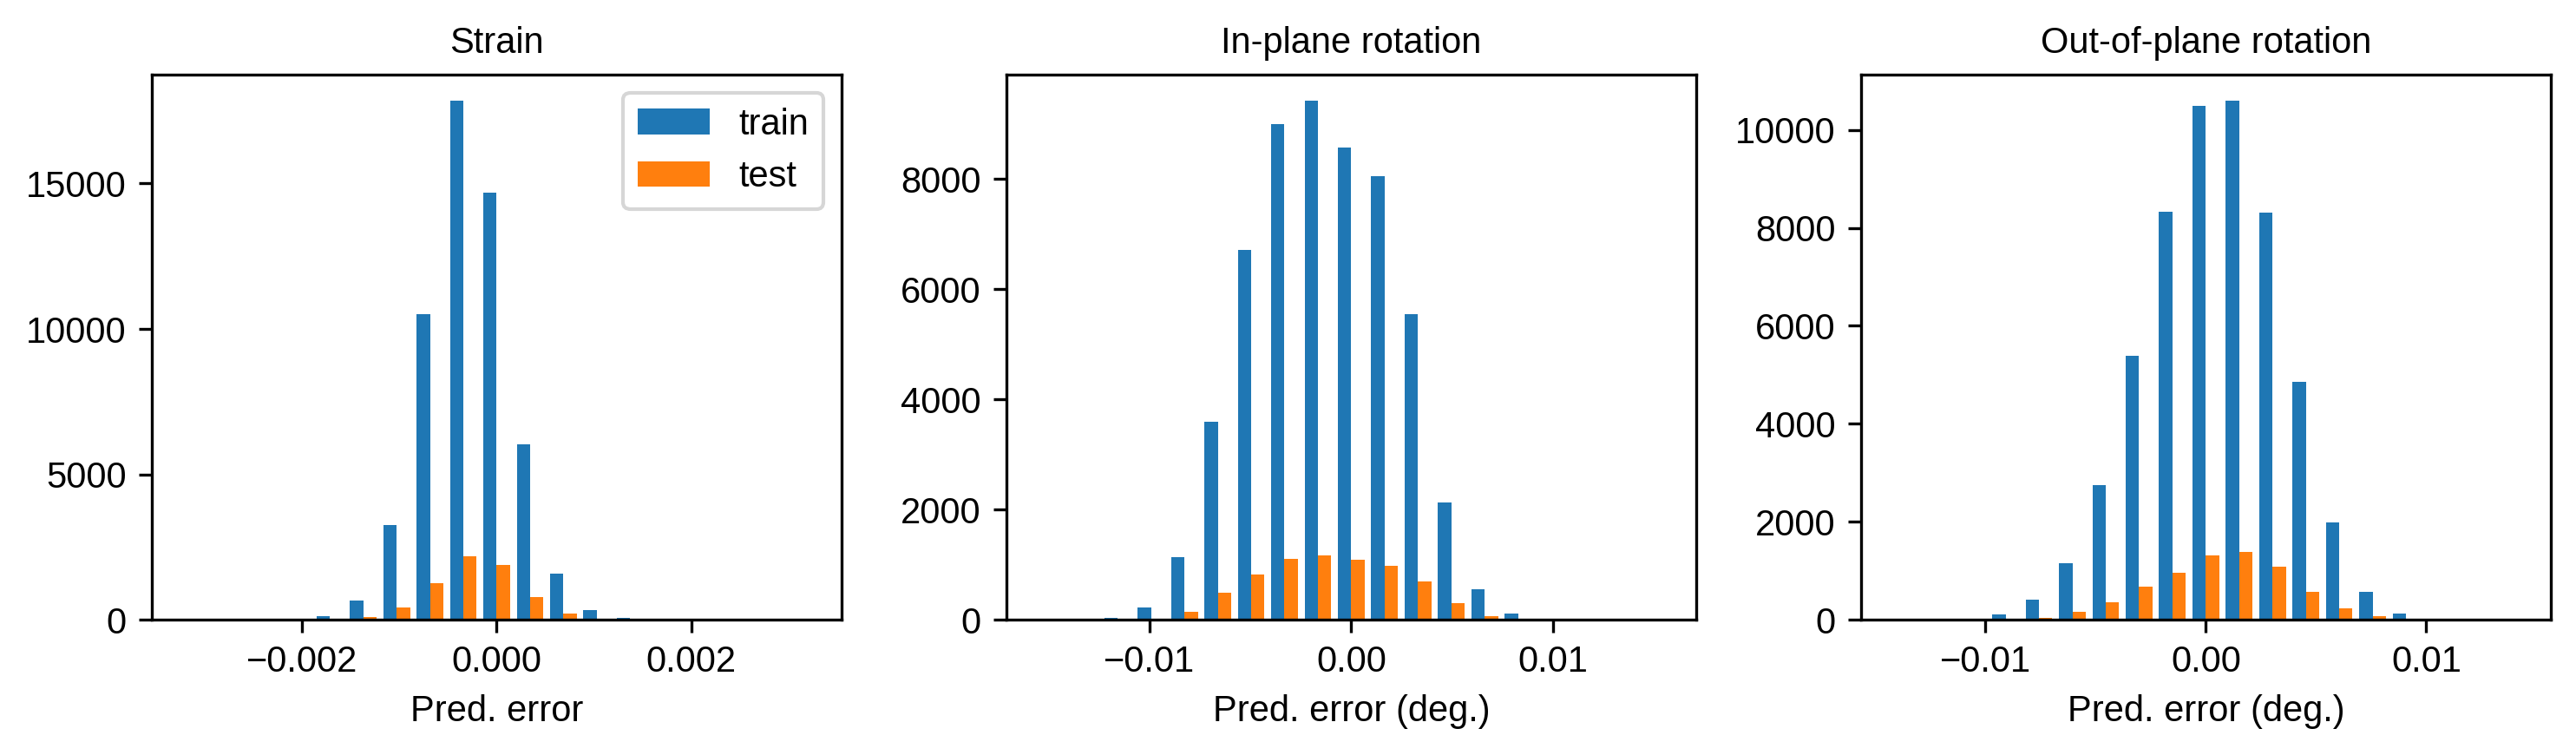

In [26]:
f, ax = plt.subplots(figsize=(10, 3), ncols=3)

ax[0].hist([x0, y0], bins0, label=['train', 'test'])
ax[0].set_xlabel('Pred. error')
ax[0].set_title('Strain')
ax[0].legend()

ax[1].hist([x1, y1], bins1, label=['train', 'test'])
ax[1].set_xlabel('Pred. error (deg.)')
ax[1].set_title('In-plane rotation')

ax[2].hist([x2, y2], bins2, label=['train', 'test'])
ax[2].set_xlabel('Pred. error (deg.)')
ax[2].set_title('Out-of-plane rotation')

plt.tight_layout()